# 120. Chatbot - seq2seq language model

## Encoder-Decoder model

- Chatbot_data_for_Korean v1.0 dataset (https://github.com/songys/Chatbot_data) 을 이용한 Chatbot model 개발

- 챗봇 트레이닝용 문답 페어 11,876개  
- 일상다반사 - 0,
- 이별(부정) - 1,
- 사랑(긍정) - 2 로 레이블링  

<img src='https://github.com/ironmanciti/NLP_Lecture/raw/master/chatbot.png' width=600>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sentencepiece as spm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

2024-11-14 18:18:43.554359: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 18:18:43.583349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 18:18:44.274905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf 
from tensorflow.python.client import device_lib

# # CUDA 버전 확인
cuda_version = tf.sysconfig.get_build_info()
print(f"CUDA Version: {cuda_version}")

# cuDNN 버전 확인
cudnn_version = tf.sysconfig.get_build_info()["cudnn_version"]
print(f"cuDNN Version: {cudnn_version}")

print(device_lib.list_local_devices() )

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


CUDA Version: OrderedDict([('cpu_compiler', '/usr/lib/llvm-16/bin/clang'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '11.8'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])
cuDNN Version: 8
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5616549685322891231
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5833228288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14951255602950706842
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:c4:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2024-11-14 18:18:45.067913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:18:45.106162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:18:45.106214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:18:45.222006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:18:45.222065: I tensorflow/compile

In [3]:
LATENT_DIM = 128                # encoding space 의 latent dimensionality
EMBEDDING_DIM = 100

Train Data 불러오기

In [4]:
df = pd.read_csv('https://raw.github.com/ironmanciti/Infran_NLP/master/data/ChatbotData.csv')
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


Data 확인

In [6]:
df.iloc[:, [0, 1]].values

array([['12시 땡!', '하루가 또 가네요.'],
       ['1지망 학교 떨어졌어', '위로해 드립니다.'],
       ['3박4일 놀러가고 싶다', '여행은 언제나 좋죠.'],
       ...,
       ['흑기사 해주는 짝남.', '설렜겠어요.'],
       ['힘든 연애 좋은 연애라는게 무슨 차이일까?', '잘 헤어질 수 있는 사이 여부인 거 같아요.'],
       ['힘들어서 결혼할까봐', '도피성 결혼은 하지 않길 바라요.']], dtype=object)

Train 용 Question, Answer data 작성

In [7]:
All_texts = []    # sentencepiece tokenizer 학습에 사용
Q_texts = []        # Encoder 입력에 사용
A_texts = []        # Decoder 입력에 사용

for Q, A in df.iloc[:, [0, 1]].values:
    Q_texts.append(Q)
    A_texts.append(A)

All_texts = Q_texts + A_texts

print(len(All_texts), len(Q_texts), len(A_texts))
print("Question :")
print(Q_texts[:5])
print("Answer :")
print(A_texts[:5])

23646 11823 11823
Question :
['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
Answer :
['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']


## Sentencepiece Tokenizer 학습을 위한 text file 생성

In [9]:
# sentencepiece는 .txt 파일을 읽으면서 진행되기 때문에 반드시 .txt를 저장후에 사용
with open('_12.chatbot_qna.txt', 'w', encoding='utf-8') as f:
    for line in All_texts:
        f.write(line + '\n')

In [10]:
input_file = '_12.chatbot_qna.txt'
vocab_size = 5000      # vocab 사이즈, 빈도 순위가 5000위에 못드는 토큰은 oov 전환
prefix = '_12.chatbot_qna' # 저장될 tokenizer 모델에 붙는 이름
pad_id = 0             #<pad> token을 0으로 설정
bos_id=1               #<s> token을 1으로 설정
eos_id=2               #</s> token을 2으로 설정
unk_id=3               #<unknown> token을 3으로 설정

cmd = f'--input={input_file} \
--pad_id={pad_id} \
--bos_id={bos_id} \
--eos_id={eos_id} \
--unk_id={unk_id} \
--model_prefix={prefix} \
--vocab_size={vocab_size}'

spm.SentencePieceTrainer.Train(cmd)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=_12.chatbot_qna.txt --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --model_prefix=_12.chatbot_qna --vocab_size=5000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: _12.chatbot_qna.txt
  input_format: 
  model_prefix: _12.chatbot_qna
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_al

학습 완료된 sentencepiece tokenizer Load

In [11]:
sp = spm.SentencePieceProcessor()
sp.Load(f'{prefix}.model')

True

In [12]:
sp.DecodeIds([170, 367, 10, 129, 16, 4])

'운 나한테이 될고.'

- Tokenize하기 전에 데이터 자체에 `<s>, </s>`를 넣어줘도 되지만, 패키지 자체에서 알아서 해주는 옵션(sp.SetEncodeExtraOptions)이 있습니다.

- `sp.SetEncodeExtraOptions('bos:eos')` : 문장 양 끝에 `<s> , </s>` 추가

In [13]:
sp.SetEncodeExtraOptions('bos:')   # 문장 처음에 <s>추가 --> Decoder Input에 사용
pieces = sp.encode_as_pieces('아버지가 방에 들어가신다')
print(pieces)
ids = sp.encode_as_ids('아버지가 방에 들어가신다')
print(ids)
print(sp.DecodePieces(pieces))
print(sp.DecodeIds(ids))

['<s>', '▁아', '버', '지', '가', '▁방', '에', '▁들어가', '신', '다']
[1, 232, 2112, 14, 7, 1467, 31, 1665, 455, 57]
아버지가 방에 들어가신다
아버지가 방에 들어가신다


In [14]:
sp.SetEncodeExtraOptions(':eos')     # 문장 끝에 </s>추가  --> Decoder target에 사용
pieces = sp.encode_as_pieces('아버지가 방에 들어가신다')
print(pieces)
ids = sp.encode_as_ids('아버지가 방에 들어가신다')
print(ids)
print(sp.DecodePieces(pieces))
print(sp.DecodeIds(ids))

['▁아', '버', '지', '가', '▁방', '에', '▁들어가', '신', '다', '</s>']
[232, 2112, 14, 7, 1467, 31, 1665, 455, 57, 2]
아버지가 방에 들어가신다
아버지가 방에 들어가신다


### Question sequence 작성

In [15]:
Q_sequences = [sp.encode_as_ids(sent) for sent in Q_texts]

print(Q_sequences[:5])

[[4228, 299, 5, 4826, 72, 2], [291, 14, 933, 674, 1735, 2], [277, 1280, 2810, 76, 2964, 94, 2], [277, 1280, 2810, 76, 667, 2964, 94, 2], [5, 4549, 4549, 3, 1395, 64, 2]]


### Answer sequence input 작성

In [16]:
sp.SetEncodeExtraOptions('bos:')  # 1로 시작
A_sequences_inputs = [sp.encode_as_ids(sent) for sent in A_texts]

print(A_sequences_inputs[:5])

[[1, 282, 7, 113, 82, 23, 4], [1, 1459, 5, 3717, 4], [1, 293, 15, 385, 39, 207, 4], [1, 293, 15, 385, 39, 207, 4], [1, 208, 970, 10, 2434, 3090, 173, 14, 40, 4]]


### Answer sequence target 작성

In [17]:
sp.SetEncodeExtraOptions(':eos')  # 2로 종료
A_sequences_targets = [sp.encode_as_ids(sent) for sent in A_texts]

print(A_sequences_targets[:5])

[[282, 7, 113, 82, 23, 4, 2], [1459, 5, 3717, 4, 2], [293, 15, 385, 39, 207, 4, 2], [293, 15, 385, 39, 207, 4, 2], [208, 970, 10, 2434, 3090, 173, 14, 40, 4, 2]]


input text의  max length 지정

Target Text 의 최대 길이 : 56
Target Text 의 최대 길이 : 76


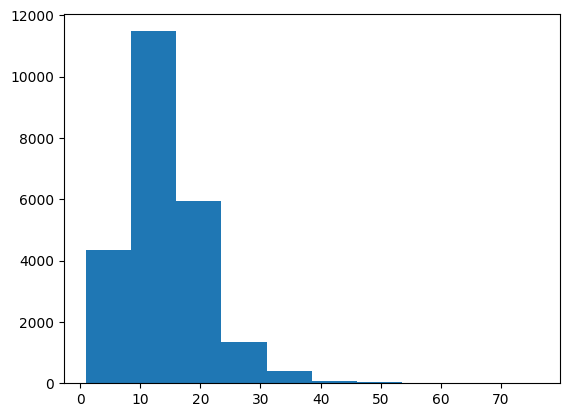

In [18]:
max_len_Q = max(len(s) for s in Q_texts)
print("Target Text 의 최대 길이 :", max_len_Q)

max_len_A = max(len(s) for s in A_texts)
print("Target Text 의 최대 길이 :", max_len_A)

plt.hist([len(s) for s in All_texts]);

Input sequence 의 최대 길이는 30 으로 정한다.

In [19]:
MAX_LEN = 30

## sequence padding


#### 주의 사항
- encoder 는 thought vector 생성 목적이므로 default (pre) 로 padding

- decoder 는 teacher forcing 을 해야하므로 post 로 padding

In [20]:
# encoder - decoder 모델에서 encoder는 pre padding / decoder는 post padding
encoder_inputs = pad_sequences(Q_sequences, maxlen=MAX_LEN, padding='pre')
print("encoder input shape :", encoder_inputs.shape)
print("encoder_inputs[0] : ", encoder_inputs[1500])

decoder_inputs = pad_sequences(A_sequences_inputs,
                               maxlen=MAX_LEN, padding="post")
print("\ndecoder input shape :", decoder_inputs.shape)
print("decoder_inputs[0] : ", decoder_inputs[1500])

decoder_targets = pad_sequences(A_sequences_targets,
                                maxlen=MAX_LEN, padding="post")
print("\nencoder target shape :", decoder_targets.shape)
print("encoder_targets[0] : ", decoder_targets[1500])

encoder input shape : (11823, 30)
encoder_inputs[0] :  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  162 1680  318
 2391    2]

decoder input shape : (11823, 30)
decoder_inputs[0] :  [   1 1145   33 3040   45    4    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

encoder target shape : (11823, 30)
encoder_targets[0] :  [1145   33 3040   45    4    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Build the model

- encoder 와 decoder 의 embedding, lstm 및 dense layer 를 training 할 목적의 model 작성  

- encoder 는 decoder 에 states [h, c] 만 전달

- prediction 을 위한 inference model 은 training model 에서 만들어진 layer 들의 weight 를 이용하여 별도 작성  

### Training : Encoder + Teacher Forcing model

In [21]:
#### Encoder
encoder_inputs_ = Input(shape=(MAX_LEN,), name='Encoder_Input')
# encoder 의 embedding layer
embedding_encoder = Embedding(vocab_size + 1, EMBEDDING_DIM)
x = embedding_encoder(encoder_inputs_)

encoder_outputs, h, c = LSTM(LATENT_DIM, return_state=True)(x)
# encoder 는 hidden state and cell state 만 decoder 로 전달
encoder_states = [h, c]  # --> thought vector

encoder_model = Model(encoder_inputs_, encoder_states)
encoder_model.summary()

2024-11-14 18:19:20.084318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 100)           500100    
                                                                 
 lstm (LSTM)                 [(None, 128),             117248    
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 617348 (2.35 MB)
Trainable params: 617348 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-11-14 18:19:20.084418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:19:20.084438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:19:20.084632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:19:20.084649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:19:20.084659: I tensorflow/compile

### Decoder model for Teacher Forcing
- Training stage에서만 사용

In [22]:
# decoder 는 [h, c] 를 initial state 로 사용
decoder_inputs_ = Input(shape=(MAX_LEN,), name='Decoder_Input')

# decoder 의 embedding layer
embedding_decoder = Embedding(vocab_size + 1, EMBEDDING_DIM)
x = embedding_decoder(decoder_inputs_)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
# initial state = encoder [h, c]
decoder_outputs, _, _ = decoder_lstm(x, initial_state=encoder_states)

# final dense layer
decoder_dense = Dense(vocab_size, activation='softmax', name='Decoder_Output')
decoder_outputs = decoder_dense(decoder_outputs)

# Teacher-forceing model  생성
model_teacher_forcing = Model([encoder_inputs_, decoder_inputs_], decoder_outputs)

#Compile the model and train it
model_teacher_forcing.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model_teacher_forcing.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder_Input (InputLayer)  [(None, 30)]                 0         []                            
                                                                                                  
 Decoder_Input (InputLayer)  [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              500100    ['Encoder_Input[0][0]']       
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 100)              500100    ['Decoder_Input[0][0]']       
                                                                                            

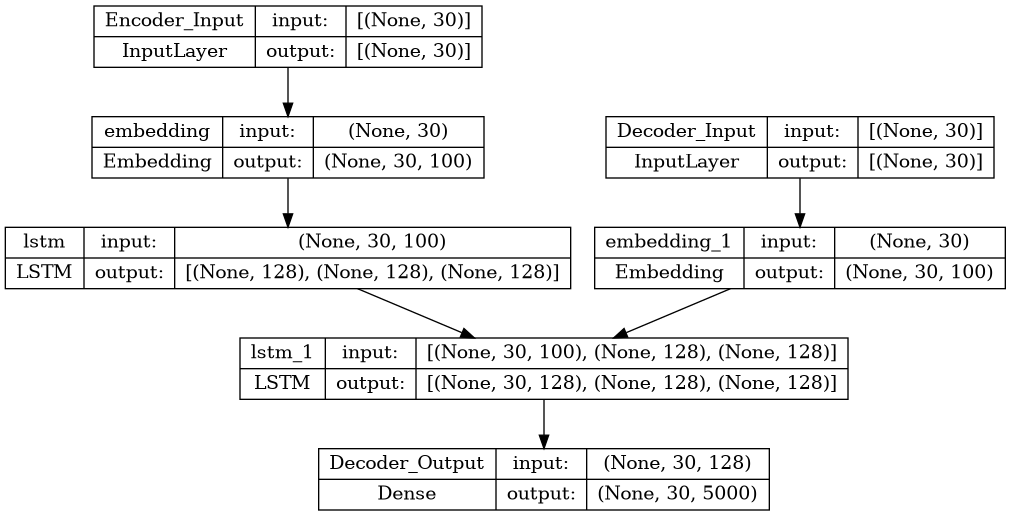

In [23]:
plot_model(model_teacher_forcing, show_shapes=True)

### Train the model

In [24]:
EPOCHS = 2
BATCH_SIZE = 256
history = model_teacher_forcing.fit([encoder_inputs, decoder_inputs],
                    decoder_targets, batch_size=BATCH_SIZE, epochs=EPOCHS,
                   validation_split=0.2)

Epoch 1/2


2024-11-14 18:21:13.573158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-14 18:21:13.600801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-14 18:21:13.625002: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff8e0023220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-14 18:21:13.625069: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-14 18:21:13.629230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 18:21:13.698617: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

37/37 [==============================] - 7s 155ms/step - loss: 5.4870 - accuracy: 0.7152 - val_loss: 2.4192 - val_accuracy: 0.6929
Epoch 2/2
37/37 [==============================] - 5s 134ms/step - loss: 1.8525 - accuracy: 0.7352 - val_loss: 2.1223 - val_accuracy: 0.6929


accuracy, loss 시각화

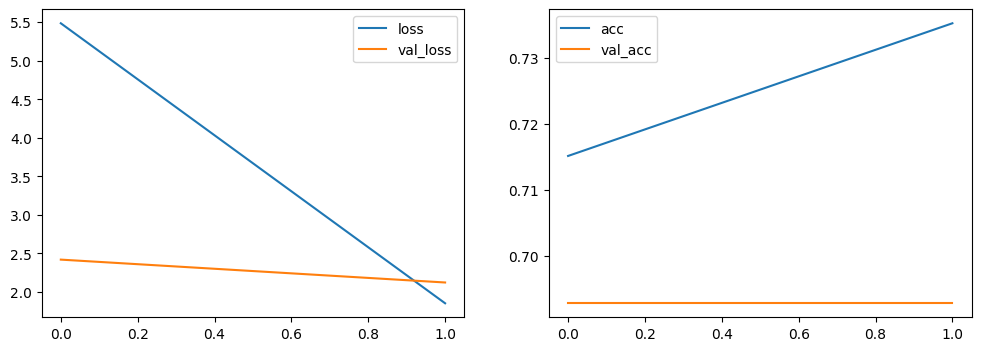

In [25]:
# plot some data
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# accuracies
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [26]:
# save model
model_teacher_forcing.save('_12.chatbot.h5')

/home/paradeigma/workspace/python/nlp_module/nlp_module_3_9/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Make Predictions - Inference phase

- prediction 을 위한 별도의 encoder model
- encoder 의 states 를 initial state 로 받는 decoder model 작성  

- encoder 는 training 단계와 동일하게 input_text 를 입력으로 받고 encoder_states 를 출력으로 하므로 이전에 define 한 encoder_input_ 과 encoder_states 변수 재사용

In [27]:
# Decoder for inference
decoder_state_input_h = Input(shape=(LATENT_DIM,), name='Decoder_hidden_h')
decoder_state_input_c = Input(shape=(LATENT_DIM,), name='Decoder_hidden_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,), name='Decoder_input')
x = embedding_decoder(decoder_inputs_single)

# output, hidden states 를 저장
decoder_outputs, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,    #decoder_model.predict([target_seq] + states_value)
    [decoder_outputs] + decoder_states
)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Decoder_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     multiple                     500100    ['Decoder_input[0][0]']       
                                                                                                  
 Decoder_hidden_h (InputLay  [(None, 128)]                0         []                            
 er)                                                                                              
                                                                                                  
 Decoder_hidden_c (InputLay  [(None, 128)]                0         []                      

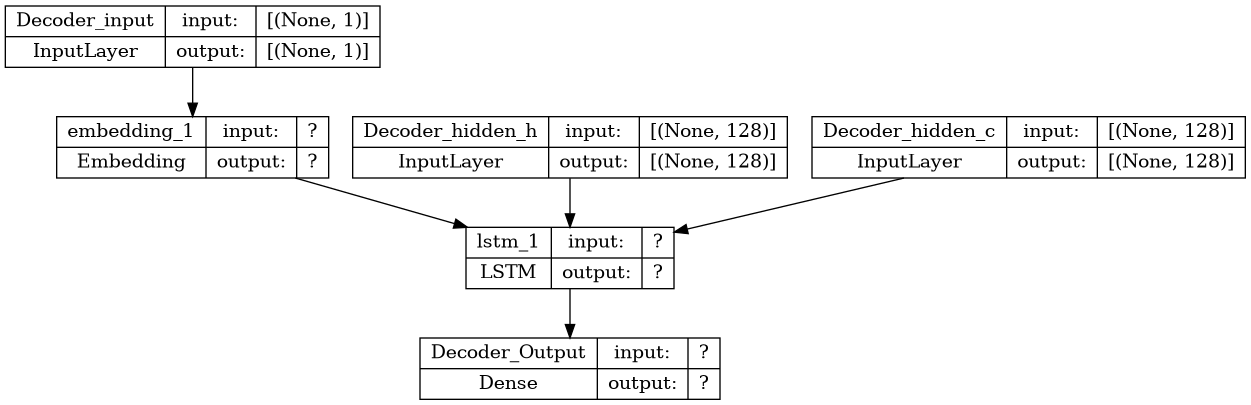

In [28]:
plot_model(decoder_model, show_shapes=True)

### 다음의 inference module 작성
- question 을 encoder 에 입력하여 thought vector 반환
- start token 설정
- 가장 확률 높은 next word 선택
- end token 생성 될 때까지 반복
- predict 결과가 sequence 로 반환되므로 index 를 word 로 변환

In [29]:
def decode_sequence(input_seq, temperature=1.0):
    # 입력된 질문을 encoder 에 입력하여 state vector 생성
    states_value = encoder_model.predict(input_seq)
    # size 1 짜리 빈 target sequence 생성
    target_seq = np.zeros((1, 1))
    # target sequence 의 첫번째 character 를 <s> 로 assign -> 1
    target_seq[0, 0] = 1
    eos = 2  # </s>

    # 답변 생성 시작
    output_ids = []
    for _ in range(max_len_A):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 확률 분포에 따라 단어 샘플링
        output_probs = output_tokens[0, 0, :]

        # 온도 조절 적용
        output_probs = np.log(output_probs + 1e-10) / temperature
        output_probs = np.exp(output_probs) / np.sum(np.exp(output_probs))

        idx = np.random.choice(len(output_probs), p=output_probs)

        if eos == idx:  # End sentence of EOS
            break

        if idx > 0:  # idx 0 은 zero padding 이므로 skip
            output_ids.append(int(idx))

        # 생성된 word 를 decoder 의 다음 input 으로 사용
        target_seq[0, 0] = idx
        # Update states
        states_value = [h, c]

    return output_ids

- sample Q & A test

In [30]:
sp.Load(f'{prefix}.model')

for _ in range(5):
    i = np.random.choice(len(Q_texts))
    input_seq = encoder_inputs[i:i+1]
    response = decode_sequence(input_seq)
    print('-')
    print('질문 :', Q_texts[i])
    print('답변 :', sp.DecodeIds(response))

1/1 [==============================] - 0s 15ms/step
-
질문 : 한달 째
답변 : 하면  없네 나쁜게.
1/1 [==============================] - 0s 15ms/step
-
질문 : 수분크림 듬뿍 바르고 자야겠다.
답변 : 원망쥬 때
1/1 [==============================] - 0s 18ms/step
-
질문 : 만난지 얼마 안됐는데 고백했어
답변 : 게렴 과거요 보지해보세요대로는
1/1 [==============================] - 0s 17ms/step
-
질문 : 개당황했잖아 갑자기 물어 봐서
답변 : 있대 조금 살아가 수정기.는
1/1 [==============================] - 0s 18ms/step
-
질문 : 헤어진 사람이 생각나는데 어떻게 견디지
답변 : 병원 없다 아니 말해보세요..


In [31]:
txt = "사랑해"
input_sequence = sp.encode_as_ids(txt)
encoder_input = pad_sequences([input_sequence], maxlen=MAX_LEN)

response = decode_sequence(encoder_input)
print('-')
print('질문', txt)
print('답변:', sp.DecodeIds(response))

1/1 [==============================] - 0s 17ms/step
-
질문 사랑해
답변: 자괴감


In [32]:
print("챗봇 대화 시작 .....")

while True:
    txt = input("질문 :")
    if txt.lower() == "quit":
        break

    input_sequence = sp.encode_as_ids(txt)
    encoder_input = pad_sequences([input_sequence], maxlen=MAX_LEN)

    answer = decode_sequence(encoder_input)

    print("답변 :", sp.DecodeIds(answer))

챗봇 대화 시작 .....
